# Correlation Coefficient of SST and Wind Speed

### Read in Data

In [1]:
%matplotlib notebook

from amsre_averaged_v7 import AMSREaveraged
from quikscat_daily_v4 import QuikScatDaily

import numpy as np
import sys
import matplotlib.pyplot as plt


In [2]:
def read_data(filename='qscat_20090120v4.gz'):
    dataset = QuikScatDaily(filename, missing=-999)
    if not dataset.variables: sys.exit('file not found')
    return dataset
dsq = read_data()

In [3]:
def read_data(filename='f32_20090120v7_d3d.gz'):
    dataset = AMSREaveraged(filename, missing=-999)
    if not dataset.variables: sys.exit('file not found')
    return dataset
dsa = read_data()

In [4]:
#asmr
#(lat,lon)
sst = dsa.variables['sst']
lonA = dsa.variables['longitude']
latA = dsa.variables['latitude']
landA = dsa.variables['land']
iceA = dsa.variables['ice']
nodataA = dsa.variables['nodata']

In [5]:
#qscat, choose ascending this time
iasc = 0
idsc = 1

#(lat,lon)
wspdA = dsq.variables['windspd'][iasc,:,:]
wspdD = dsq.variables['windspd'][idsc,:,:]
lonQ = dsq.variables['longitude']
latQ = dsq.variables['latitude']
scatflagA = dsq.variables['scatflag'][iasc,:,:]
scatflagQ = dsq.variables['scatflag'][idsc,:,:]
landQA = dsq.variables['land'][iasc,:,:]
landQD = dsq.variables['land'][idsc,:,:]
iceQA = dsq.variables['ice'][iasc,:,:]
iceQD = dsq.variables['ice'][idsc,:,:]
nodataQA = dsq.variables['nodata'][iasc,:,:]
nodataQD = dsq.variables['nodata'][idsc,:,:]

In [6]:
#turns -999 data into NaN
#for j in range(sst.shape[0]):
#    for i in range(sst.shape[1]):
#        if sst[j][i] == -999:
#            sst[j][i] = None

         
#for j in range(wspdA.shape[0]):
#    for i in range(wspdA.shape[1]):
#        if wspdA[j][i] == -999:
#            wspdA[j][i] = None
                    
#for j in range(wspdD.shape[0]):
#    for i in range(wspdD.shape[1]):
#        if wspdD[j][i] == -999:
#            wspdD[j][i] = None

sst[np.where(sst == -999)] = None
wspdA[np.where(wspdA == -999)] = None
wspdD[np.where(wspdD == -999)] = None

### Get Slices of Data

In [7]:
#lat and lon arrays are the same 

def are_equal(array1,array2):
    comparison = array1 == array2
    equal_arrays = comparison.all()
    return equal_arrays

print(are_equal(latA,latQ))
print(are_equal(lonA,lonQ))

True
True


In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#, array[idx]


def data_sliceQ(lat,lon,data):
    
    indi = find_nearest(latQ, lat[0])
    indf = find_nearest(latQ, lat[1])
    sl = np.arange(indi, indf)
    latslQ = latQ[sl]
    
    indi2 = find_nearest(lonQ,lon[0])
    indf2 = find_nearest(lonQ,lon[1])
    sl = np.arange(indi2, indf2)
    lonslQ = lonQ[sl]
    
    wspdsl = data[indi:indf, indi2:indf2]
    return wspdsl


def data_sliceA(lat,lon,data):

    indi = find_nearest(latA, lat[0])
    indf = find_nearest(latA, lat[1])
    sl = np.arange(indi, indf)
    latslA = latA[sl]

    indi2 = find_nearest(lonA,lon[0])
    indf2 = find_nearest(lonA, lon[1])
    sl = np.arange(indi2, indf2)
    lonslA = lonA[sl]

    datasl = data[indi:indf, indi2:indf2]

    return latslA, lonslA, datasl

## Correlation Coefficient

In [9]:
def clean_data(data1,data2):
    """
    Description: finds the locations of NaN within two data sets and then deletes
        the Nan in its origin array and the other data array. 
    
    Paramaters: takes two arrays of data that are the same length
    
    Returns: the two given parameters with NaN data removed
    """
    
    bad_ind = np.where((np.isnan(data1) == True) | (np.isnan(data2) == True))
    clean_data1 = np.delete(data1,bad_ind)
    clean_data2 = np.delete(data2,bad_ind)
    
    return clean_data1, clean_data2


### Checking if Clean_data works for Corr Coeff

In [10]:
wspdsl = data_sliceQ([39,48],[158,178],wspdA)
lat4, lon4, sstsl = data_sliceA([39,48],[158,178],sst)
sstsl_1D = sstsl.flatten()
wspdsl_1D = wspdsl.flatten()

r1 = np.corrcoef(sstsl_1D, wspdsl_1D)
print("Correlation Coefficient of SST and Wind (no clean) at this location is:",r1[0,1])


#---------try original slice to test that my function works ----------
sstsl_cl, wspdsl_cl = clean_data(sstsl_1D,wspdsl_1D)
r2 = np.corrcoef(sstsl_cl, wspdsl_cl)
print("Correlation Coefficient of SST and Wind (clean) at this location is:",r2[0,1])
print("No clean = clean in space with no NaN, so the function clean_data passes the test.")


#---------try original slice but expand it to encompass a couple NaN points-------

wspdsl = data_sliceQ([38,48],[158,178],wspdA)
lat6, lon6, sstsl = data_sliceA([38,48],[158,178],sst)

sstsl = sstsl.flatten()
wspdsl = wspdsl.flatten()
sstsl_cl, wspdsl_cl = clean_data(sstsl,wspdsl)
r3 = np.corrcoef(sstsl_cl, wspdsl_cl)
print("Correlation Coefficient of SST and Wind at this location is:",r3[0,1])


Correlation Coefficient of SST and Wind (no clean) at this location is: 0.5509546721098764
Correlation Coefficient of SST and Wind (clean) at this location is: 0.5509546721098764
No clean = clean in space with no NaN, so the function clean_data passes the test.
Correlation Coefficient of SST and Wind at this location is: 0.554101942441192


### Function to get correlation coeff of slice, cleans data

In [11]:
def corrcoeff_slcl(lat,lon,dataQ,dataA):
    data1 = data_sliceQ([lat[0],lat[1]],[lon[0],lon[1]],dataQ)
    data2 = data_sliceQ([lat[0],lat[1]],[lon[0],lon[1]],dataA)
    data1_1D = data1.flatten()
    data2_1D = data2.flatten()
    data1_cl,data2_cl = clean_data(data1_1D,data2_1D)
    r = np.corrcoef(data1_cl,data2_cl)
    return r[0,1]

def corrcoeff_cl(dataQ,dataA):
    dataQ_1D = dataQ.flatten()
    dataA_1D = dataA.flatten()
    dataQ_cl,dataA_cl = clean_data(dataQ_1D,dataA_1D)
    r = np.corrcoef(dataQ_cl,dataA_cl)
    return r[0,1]


In [12]:
#is the same as above, proves function corrcoeff_slcl works
print(corrcoeff_slcl([39,48],[158,178],wspdA,sst))

0.5509546721098764


## Exploring Ascending vs Descending Wind Track

In [13]:
#-----Corr Coeff betwenn wind asc and wind desc------
r4 = corrcoeff_cl(wspdA, wspdD)
print("Corr Coeff of Wind Descending with Wind Ascending Everywhere is",r4)

r5 = corrcoeff_slcl([39,48],[158,178],wspdA,sst)
print("Corr Coeff of Wind Descending with Wind Ascending is",r5)


Corr Coeff of Wind Descending with Wind Ascending Everywhere is 0.6022085985262177
Corr Coeff of Wind Descending with Wind Ascending is 0.5509546721098764


In [14]:
#-------Compare using Wind Asc vs. Wind Desc for SST/Wind Corr Coeff-------
r6 = corrcoeff_cl(wspdA,sst)
r7 = corrcoeff_cl(wspdD,sst)
print("Corr Coeff of SST with Wind Ascending Everywhere is",r6)
print("Corr Coeff of SST with Wind Descending Everywhere is",r7)


r8 = corrcoeff_slcl([39,48],[158,178],wspdA,sst)
r9 = corrcoeff_slcl([39,48],[158,178],wspdD,sst)
print("Corr Coeff of SST with Wind Ascending Slice is",r8)
print("Corr Coeff of SST with Wind Descending Slice is",r9)


Corr Coeff of SST with Wind Ascending Everywhere is -0.2035675092801988
Corr Coeff of SST with Wind Descending Everywhere is -0.2238667449450772
Corr Coeff of SST with Wind Ascending Slice is 0.5509546721098764
Corr Coeff of SST with Wind Descending Slice is 0.34294609336854326


In [15]:
# correlation slices with WIND AVG of asc and desc and SST
latsl = [39,48]
lonsl = [158,178]

wspdAsl = data_sliceQ(latsl,lonsl,wspdA)
wspdDsl = data_sliceQ(latsl,lonsl,wspdD)
lat3, lon3, sstsl = data_sliceA(latsl,lonsl,sst)
wspdA_1D = wspdAsl.ravel()
sstsl_1D = sstsl.ravel()
np.asarray(sstsl_1D)
wspdD_1D = wspdDsl.ravel()



#---------Method 1--------- ---
wspdsum = np.add(wspdD_1D,wspdA_1D)
#wspdsum = wspdD_1D + wspdA_1D
wspd_avg1D = wspdsum/2
r10 = corrcoeff_cl(wspd_avg1D,sstsl_1D)
print("Corr Coeff of SST and Wind (Asc & Desc Averaged) slice, deleting NaNs is:",r10)



#----------Method 2-----------

wspd_avg2 = np.empty(len(wspdD_1D))
both_NaN = np.where((np.isnan(wspdD_1D) == False) & (np.isnan(wspdA_1D) == False))
wspd_avg2[both_NaN] = (wspdD_1D[both_NaN] + wspdA_1D[both_NaN])/2

D_NaN = np.where((np.isnan(wspdD_1D) == True) & (np.isnan(wspdA_1D) == False))
wspd_avg2[D_NaN] = wspdA_1D[D_NaN]

A_NaN = np.where((np.isnan(wspdD_1D) == False) & (np.isnan(wspdA_1D) == True))
wspd_avg2[A_NaN] = wspdD_1D[A_NaN]

sst_cl, wspdavg2_cl = clean_data(sstsl_1D,wspd_avg2)

r11 = np.corrcoef(sst_cl, wspdavg2_cl)
print("Corr Coeff of SST and Wind (Asc & Desc Averaged) slice, replacing some NaNs is:",r11[0,1])


Corr Coeff of SST and Wind (Asc & Desc Averaged) slice, deleting NaNs is: 0.5404018284778542
Corr Coeff of SST and Wind (Asc & Desc Averaged) slice, replacing some NaNs is: 0.5605521876111017


In [16]:
def wspdaverage(lat,lon):
    latsl,lonsl,Asl = data_sliceA([lat[0],lat[1]],[lon[0],lon[1]],wspdA)
    Dsl = data_sliceQ([lat[0],lat[1]],[lon[0],lon[1]],wspdD)
    
    #--------Method 1----------
    wspdsum = np.add(Dsl,Asl)
    #wspdsum = wspdD_1D + wspdA_1D
    wspd_avg1 = wspdsum/2
    
    #---------Method 2 --------
    wspd_avg2 = np.empty([len(latsl),len(lonsl)])
    for i in range(len(latsl)):
        D = Dsl[i][:]
        A = Asl[i][:]
    
        both_NaN = np.where((np.isnan(D) == False) & (np.isnan(A) == False))
        wspd_avg2[i][both_NaN] = (D[both_NaN] + A[both_NaN])/2

        D_NaN = np.where((np.isnan(D) == True) & (np.isnan(A) == False))
        wspd_avg2[i][D_NaN] = A[D_NaN]

        A_NaN = np.where((np.isnan(D) == False) & (np.isnan(A) == True))
        wspd_avg2[i][A_NaN] = D[A_NaN]

        
    return latsl, lonsl, wspd_avg1, wspd_avg2


In [17]:
#CORRELATION
lat2 = [39,48]
lon2 = [158,178]
l, l, w_avg1, w_avg2 = wspdaverage(lat2,lon2)

r12 = corrcoeff_cl(w_avg1,data_sliceQ(lat2,lon2,sst))
r13 = corrcoeff_cl(w_avg2, data_sliceQ(lat2,lon2,sst))
print("Corr Coeff of Wind Avg1 with SST Slice is",r12)
print("Corr Coeff of Wind Avg2 with SST Slice is",r13)


Corr Coeff of Wind Avg1 with SST Slice is 0.5404018284778542
Corr Coeff of Wind Avg2 with SST Slice is 0.5605521876111017


<IPython.core.display.Javascript object>


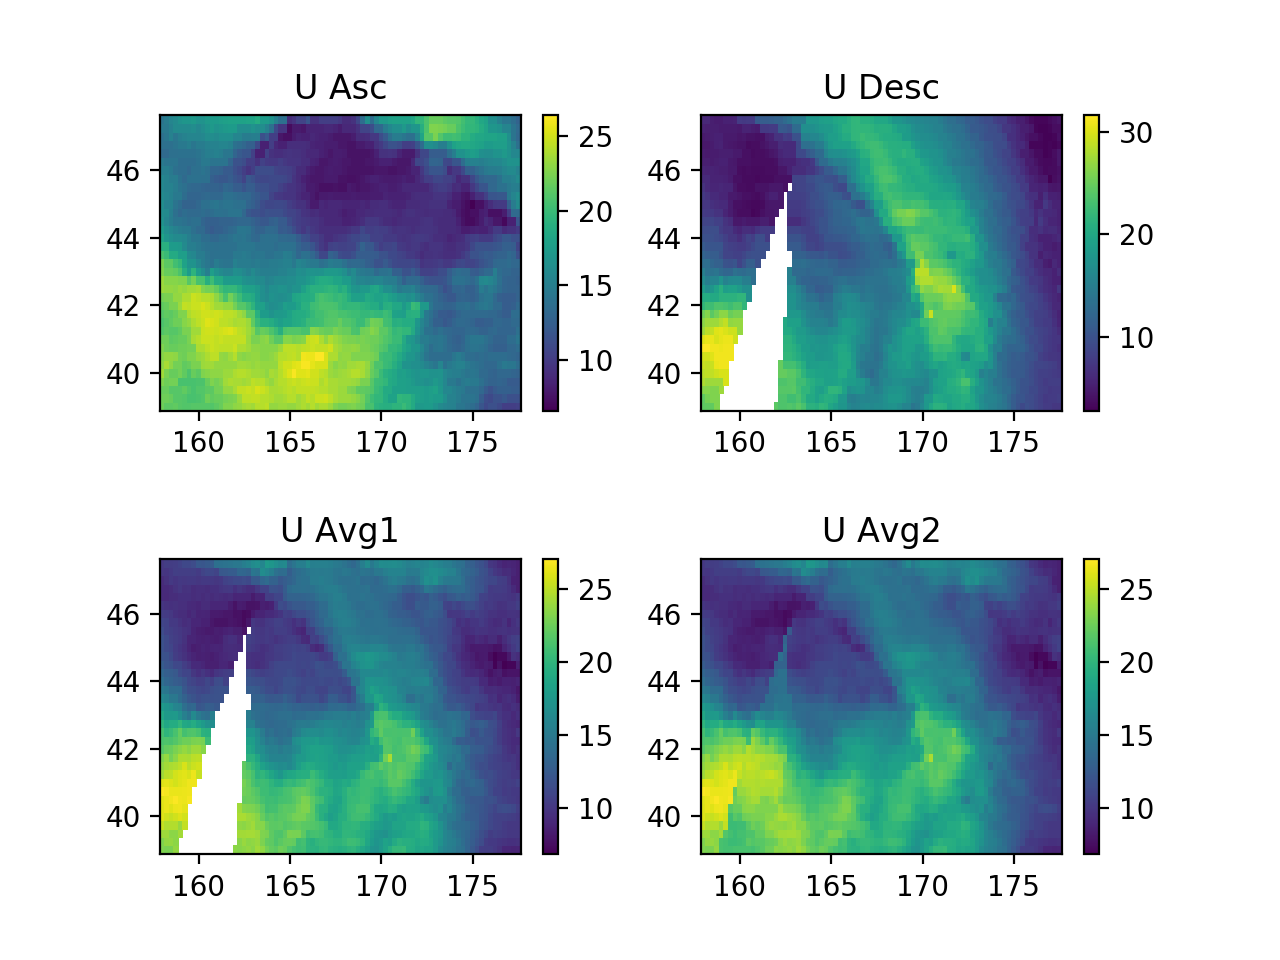

In [18]:
latsl = [39,48]
lonsl = [158,178]


ltsl,lnsl,wspd_avg1,wspd_avg2 = wspdaverage(latsl,lonsl)
sstsl = data_sliceQ(latsl,lonsl,sst)
wspdAsl = data_sliceQ(latsl,lonsl,wspdA)
wspdDsl = data_sliceQ(latsl,lonsl,wspdD)


fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.5)

ax = axs[0,0]
pc = ax.pcolormesh(lnsl,ltsl,wspdAsl)#-wspdAsl.mean())
ax.set_title('U Asc')# (Mean Removed)')
cbar1 = fig.colorbar(pc,ax=ax)

ax = axs[0,1]
pc = ax.pcolormesh(lnsl,ltsl,wspdDsl)#-wspdDsl.mean())
ax.set_title('U Desc')# (Mean Removed)')
cbar2 = fig.colorbar(pc,ax=ax)


ax = axs[1,0]
pc = ax.pcolormesh(lnsl,ltsl,wspd_avg1)
ax.set_title('U Avg1')
cbar3 = fig.colorbar(pc,ax=ax)

ax = axs[1,1]
pc = ax.pcolormesh(lnsl,ltsl,wspd_avg2)
ax.set_title('U Avg2')
cbar4 = fig.colorbar(pc,ax=ax)


## Correlation Coeff with scat flag in and out

Scatflag has values -999, 0, or 1. Value -999 is land or missing data. Value 0 = no rain and 1 = rain

In [19]:
#Correlation WITH rain
r14 = corrcoeff_slcl([39,48],[158,178],wspdA,sst)
print("Corr Coef of SST and Wind with rain:",r14)

#remove rain data
rain_ind = np.where(scatflagA == 1)
wspdA_norain = wspdA
wspdA_norain[rain_ind] = None
sst_norain = sst
sst_norain[rain_ind] = None

#How many places have rain?
print('Amount of rain everywhere:',np.count_nonzero(scatflagA))
scatflagA_sl = data_sliceQ([39,48],[158,178],scatflagA)
print('Amount of rain in slice:', np.count_nonzero(scatflagA_sl))

#Correlation WITHOUT rain
r15 = corrcoeff_slcl([39,48],[158,178],wspdA_norain,sst_norain)
print("Corr Coeff of SST and Wind NO rain:",r15)


Corr Coef of SST and Wind with rain: 0.5509546721098764
Amount of rain everywhere: 618547
Amount of rain in slice: 390
Corr Coeff of SST and Wind NO rain: 0.5467169065957044


## Correlation Coeff of spatial lag

<IPython.core.display.Javascript object>


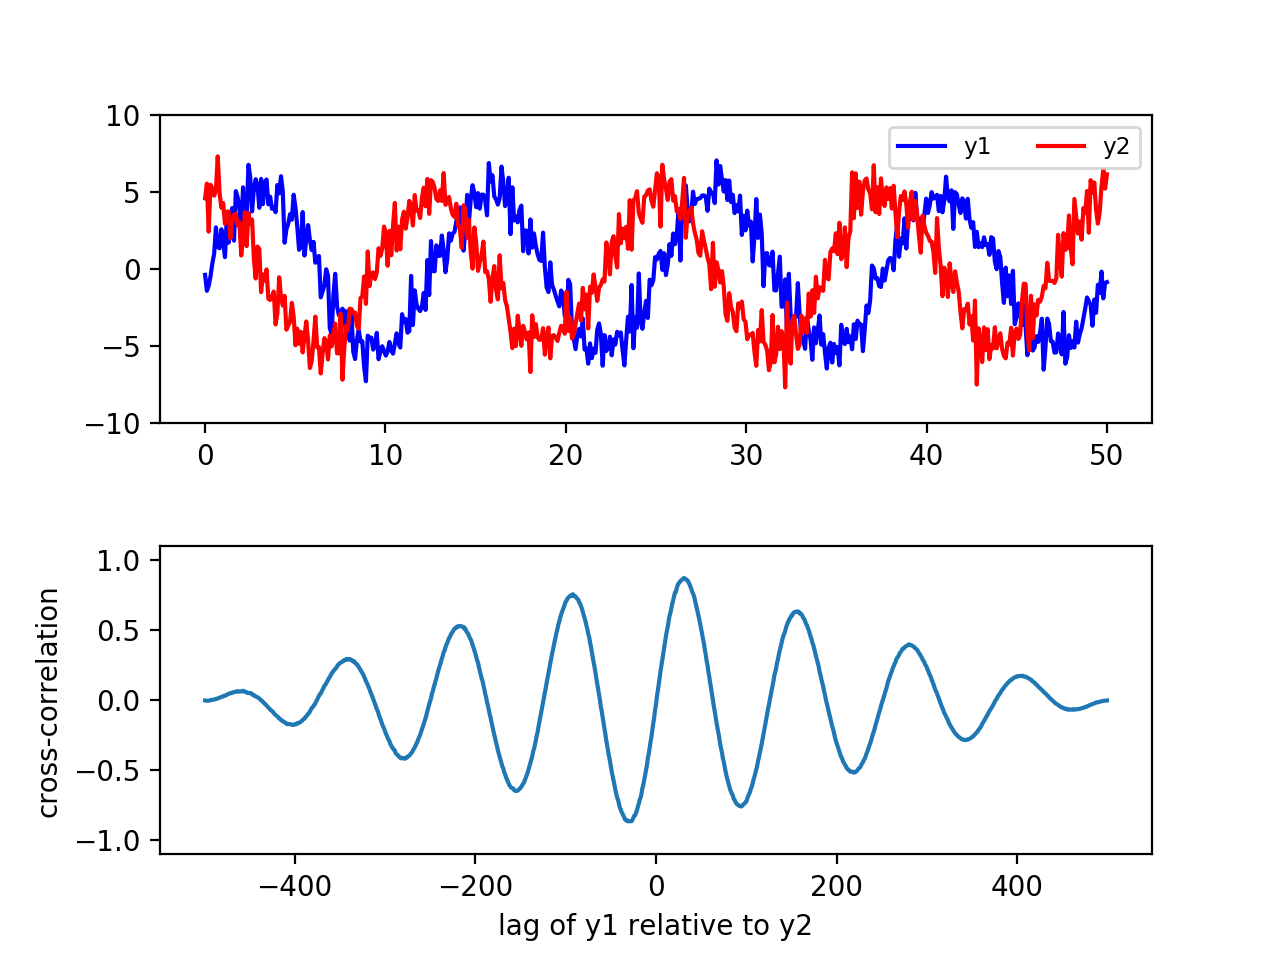

max correlation is at lag 31


In [20]:
npts = 500
x = np.linspace(0, 50, npts)
y1 = 5 * np.sin(x/2) + np.random.randn(npts)
y2 = 5 * np.cos(x/2) + np.random.randn(npts)

lags = np.arange(-npts + 1, npts) 
#increments by 1 from -499 to +499

ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
#covariance???

ccor = ccov / (npts * y1.std() * y2.std())
#correlation 

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='y1')
ax.plot(x, y2, 'r', label='y2')
ax.set_ylim(-10, 10)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-1.1, 1.1)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)

In [21]:
def corr_spatiallag_lon(lat,lon,data1,data2):
    """
    Description: 
    
    Paramaters:
    
    Returns: 
    """
        
    data1sl = data_sliceQ([lat[0],lat[1]],[lon[0],lon[1]],data1)
    data1_1D = data1sl.flatten()
    
    dist = 30
    lags = np.arange(-dist + 1, dist)
    corr_lag = np.zeros((len(lags)))
    
    for i in lags:
        data2sl = data_sliceQ([lat[0],lat[1]],[lon[0]+i,lon[1]+i],data2)
        data2_1D = data2sl.flatten()
        data1_cl,data2_cl = clean_data(data1_1D,data2_1D)
        corr_lag[i] = np.corrcoef(data1_cl,data2_cl)[0,1]  
    
    return lags, corr_lag


def corr_spatiallag_lat(lat,lon,data1,data2):
    """
    Description: ... Data1 stays in the same place and Data 2 shifts with latitude
    
    Paramaters: 
    
    Returns: 
    """
    
    data1sl = data_sliceQ([lat[0],lat[1]],[lon[0],lon[1]],data1)
    data1_1D = data1sl.flatten()
    
    dist = 30
    lags = np.arange(-dist + 1, dist)
    corr_lag = np.zeros((len(lags)))
    
    for i in lags:
        data2sl = data_sliceQ([lat[0]+i,lat[1]+i],[lon[0],lon[1]],data2)
        data2_1D = data2sl.flatten()
        data1_cl,data2_cl = clean_data(data1_1D,data2_1D)
        corr_lag[i] = np.corrcoef(data1_cl,data2_cl)[0,1]  
    
    return lags, corr_lag

#complete later
def corr_spatiallag_r():
    return None 



<IPython.core.display.Javascript object>


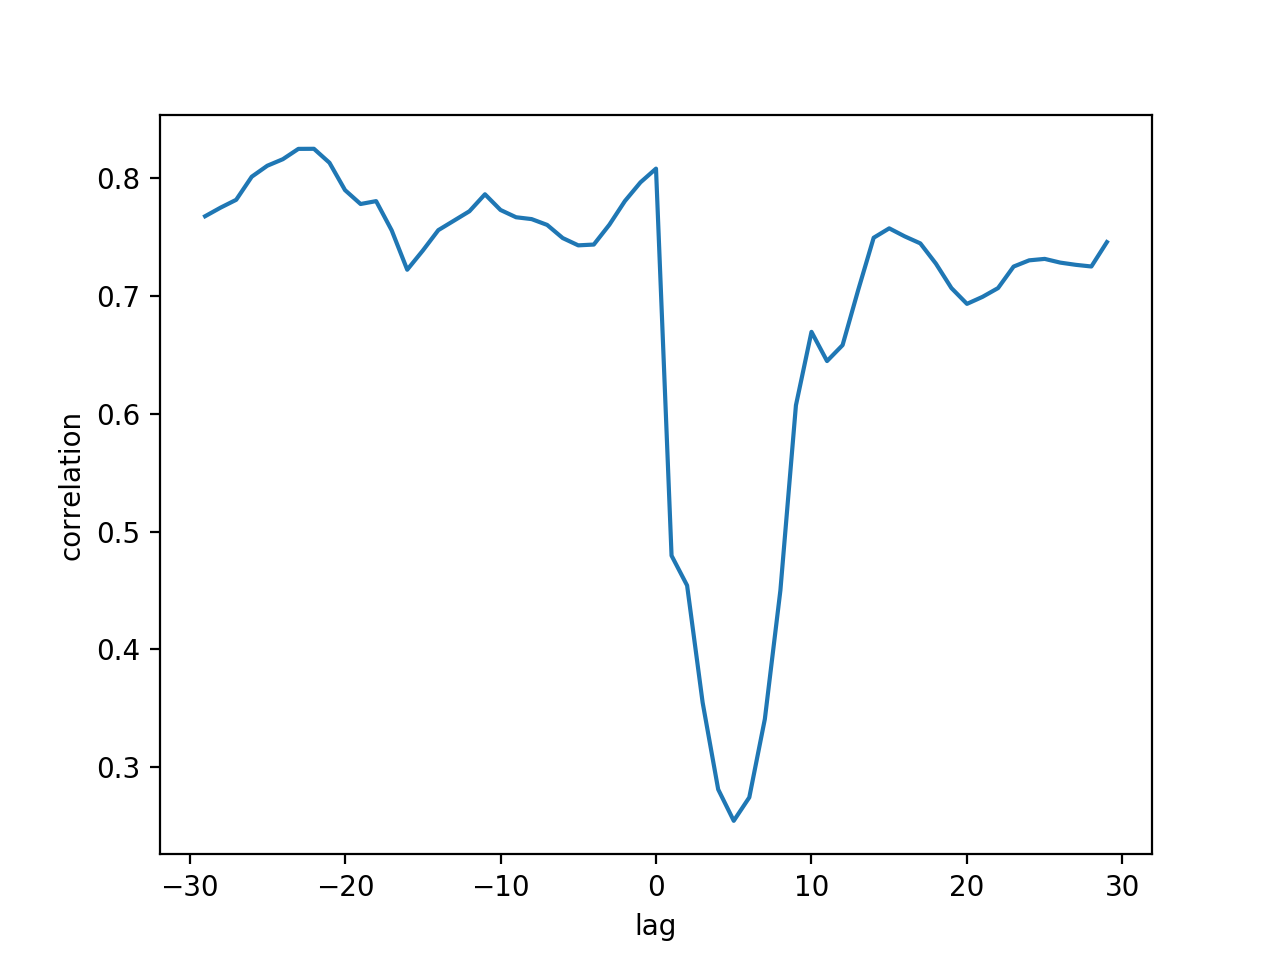

Text(0.5, 0, 'lag')

In [22]:
latsl2 = [39,48]
lonsl2 = [158,168]

lags_lon, corr_lon = corr_spatiallag_lon(latsl2,lonsl2,wspdA,sst)


fig, ax = plt.subplots()
ax.plot(lags_lon,corr_lon)
ax.set_ylabel('correlation')
ax.set_xlabel('lag')

<IPython.core.display.Javascript object>


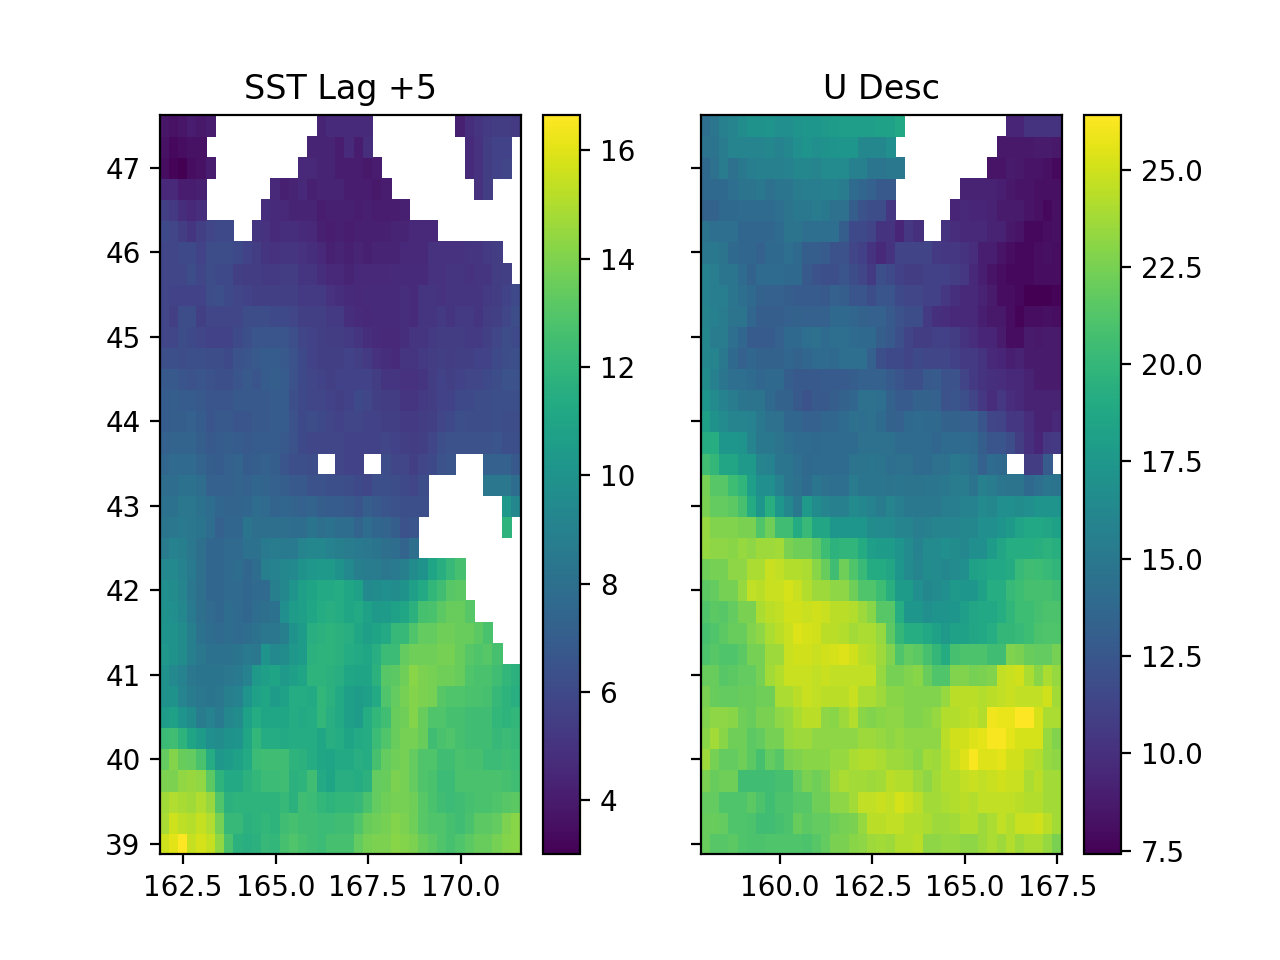

In [23]:
#in the case above, low correlation is at lag 5
lag = 4
lat6, lon6, sst_lag4 = data_sliceA([latsl2[0],latsl2[1]],[lonsl2[0]+lag,lonsl2[1]+lag],sst)
lat7, lon7, wspd_lag4 = data_sliceA([latsl2[0],latsl2[1]],[lonsl2[0],lonsl2[1]],wspdA)


fig, axs = plt.subplots(ncols=2,sharey=True)
fig.subplots_adjust(hspace=.5)

ax = axs[0]
pc = ax.pcolormesh(lon6,lat6,sst_lag4)
ax.set_title('SST Lag +5')
cbar1 = fig.colorbar(pc,ax=ax)


ax = axs[1]
pc = ax.pcolormesh(lon7,lat7,wspd_lag4)
ax.set_title('U Desc')
cbar2 = fig.colorbar(pc,ax=ax)


<IPython.core.display.Javascript object>


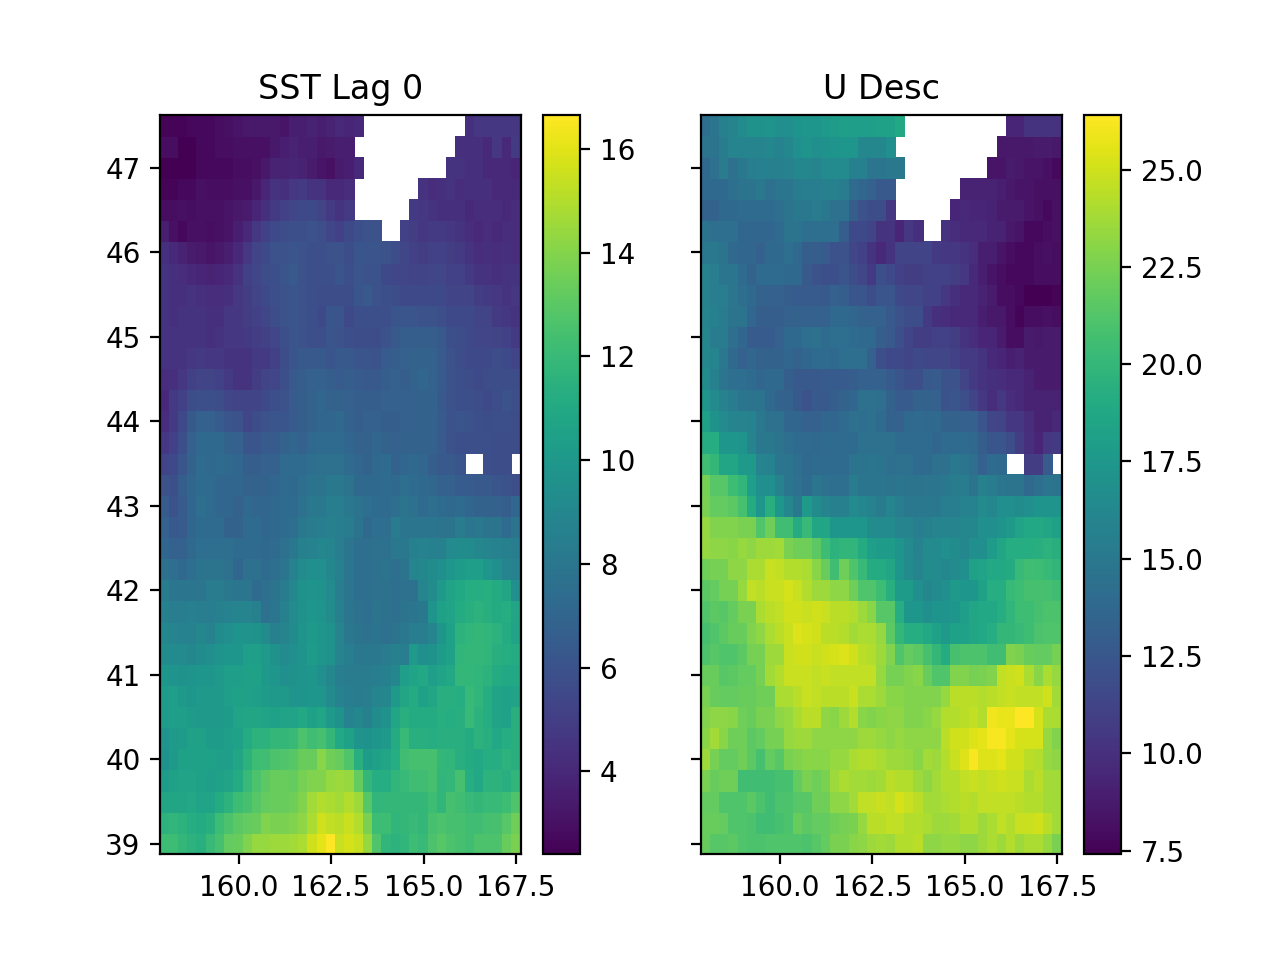

In [24]:
#in the case above, high correlation is at lag ...

lag = 0
lat8, lon8, sst_lag11 = data_sliceA([latsl2[0],latsl2[1]],[lonsl2[0]+lag,lonsl2[1]+lag],sst)
lat9, lon9, wspd_lag11 = data_sliceA([latsl2[0],latsl2[1]],[lonsl2[0],lonsl2[1]],wspdA)


fig, axs = plt.subplots(ncols=2,sharey=True)
fig.subplots_adjust(hspace=.5)

ax1 = axs[0]
pc = ax1.pcolormesh(lon8,lat8,sst_lag11)
ax1.set_title('SST Lag 0')
cbar1 = fig.colorbar(pc,ax=ax1)

ax2 = axs[1]
pc = ax2.pcolormesh(lon9,lat9,wspd_lag11)
ax2.set_title('U Desc')
cbar2 = fig.colorbar(pc,ax=ax2)


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<IPython.core.display.Javascript object>


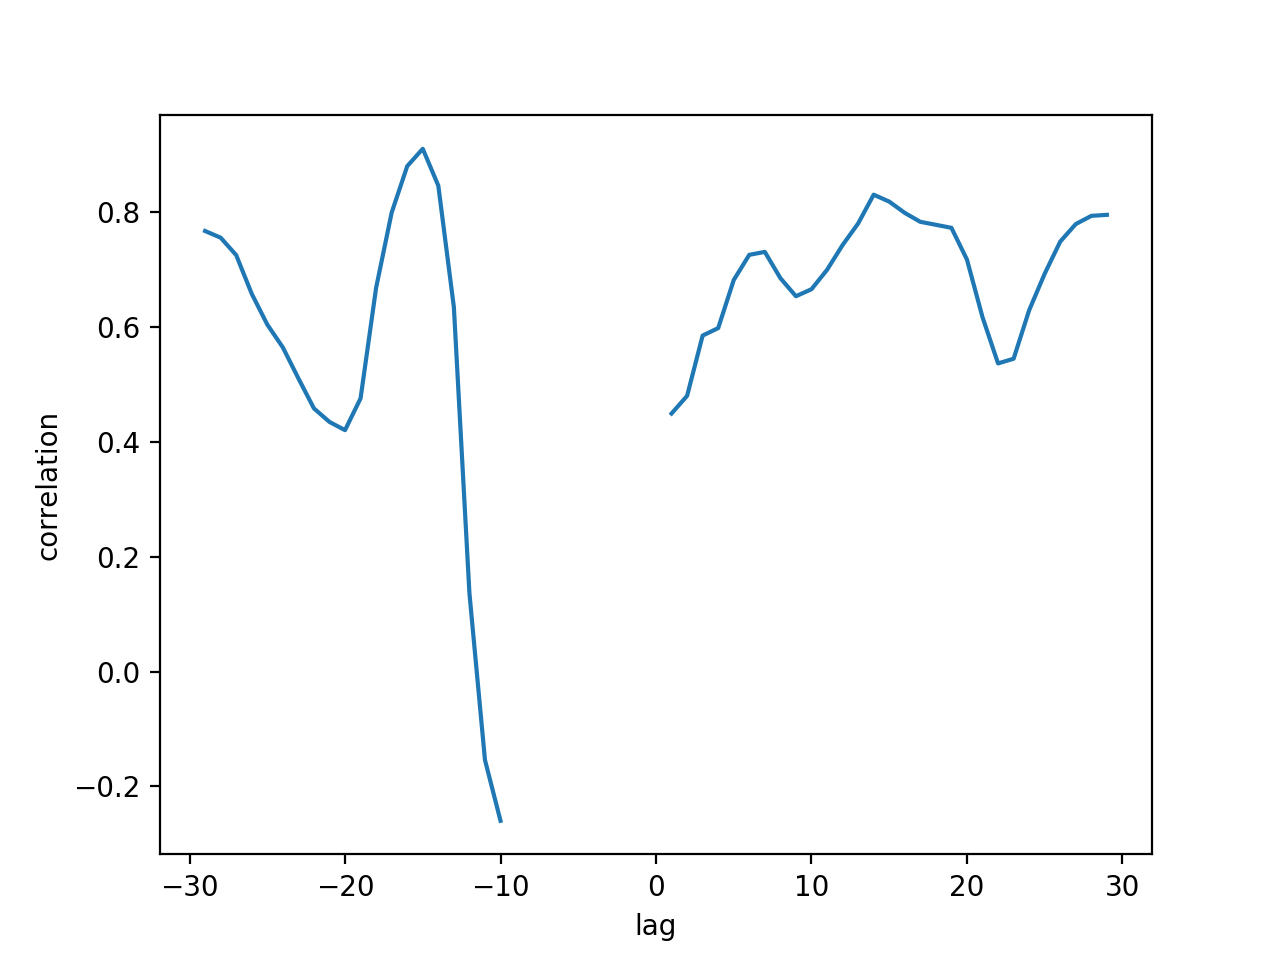

Text(0.5, 0, 'lag')

In [25]:
lags_lat, corr_lat = corr_spatiallag_lat([39,48],[158,168],wspdA,sst)

fig, ax = plt.subplots()
ax.plot(lags_lat,corr_lat)
ax.set_ylabel('correlation')
ax.set_xlabel('lag')

0.7176395950845657


<IPython.core.display.Javascript object>


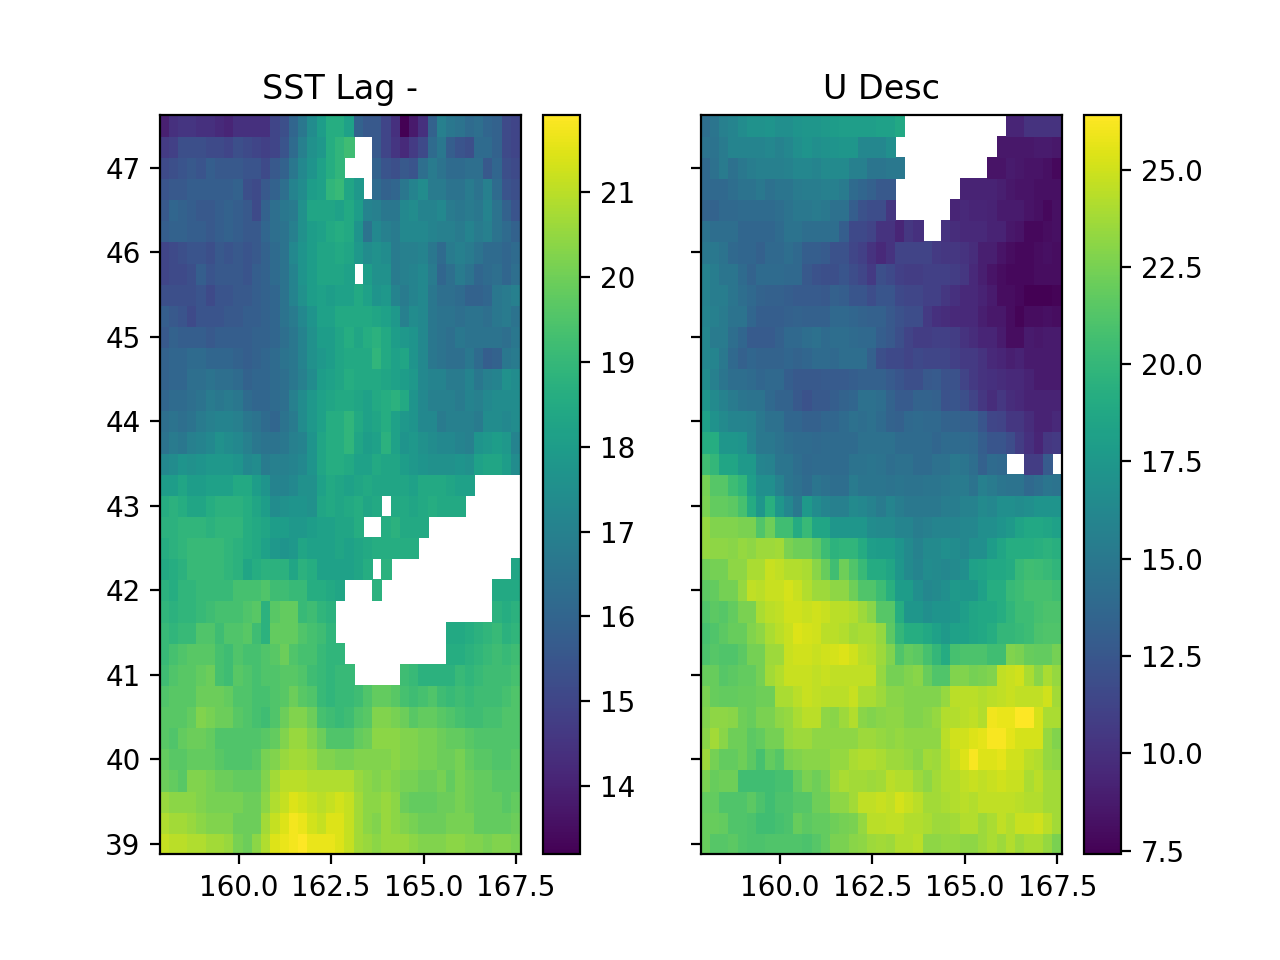

In [26]:
lagy = -10

lat10, lon10, sst_lagy = data_sliceA([latsl2[0]+lagy,latsl2[1]+lagy],[lonsl2[0],lonsl2[1]],sst)
lat11, lon11, wspd_lagy = data_sliceA([latsl2[0],latsl2[1]],[lonsl2[0],lonsl2[1]],wspdA)

#find out why there is a gap in the lag calculations
#correlation between sst_lagy and wspd_lagy has a value, so why doesn't it work above?!
sst_lagy1D = sst_lagy.flatten()
wspd_lagy1D = wspd_lagy.flatten()
wspd_lagy_cl,sst_lagy_cl = clean_data(wspd_lagy1D,sst_lagy1D)
print(np.corrcoef(wspd_lagy_cl,sst_lagy_cl)[0,1])


#plot where correlation is low
fig, axs = plt.subplots(ncols=2,sharey=True)
fig.subplots_adjust(hspace=.5)

ax1 = axs[0]
pc = ax1.pcolormesh(lon10,lat8,sst_lagy)
ax1.set_title('SST Lag -')
cbar1 = fig.colorbar(pc,ax=ax1)

ax2 = axs[1]
pc = ax2.pcolormesh(lon11,lat11,wspd_lagy)
ax2.set_title('U Desc')
cbar2 = fig.colorbar(pc,ax=ax2)


<IPython.core.display.Javascript object>


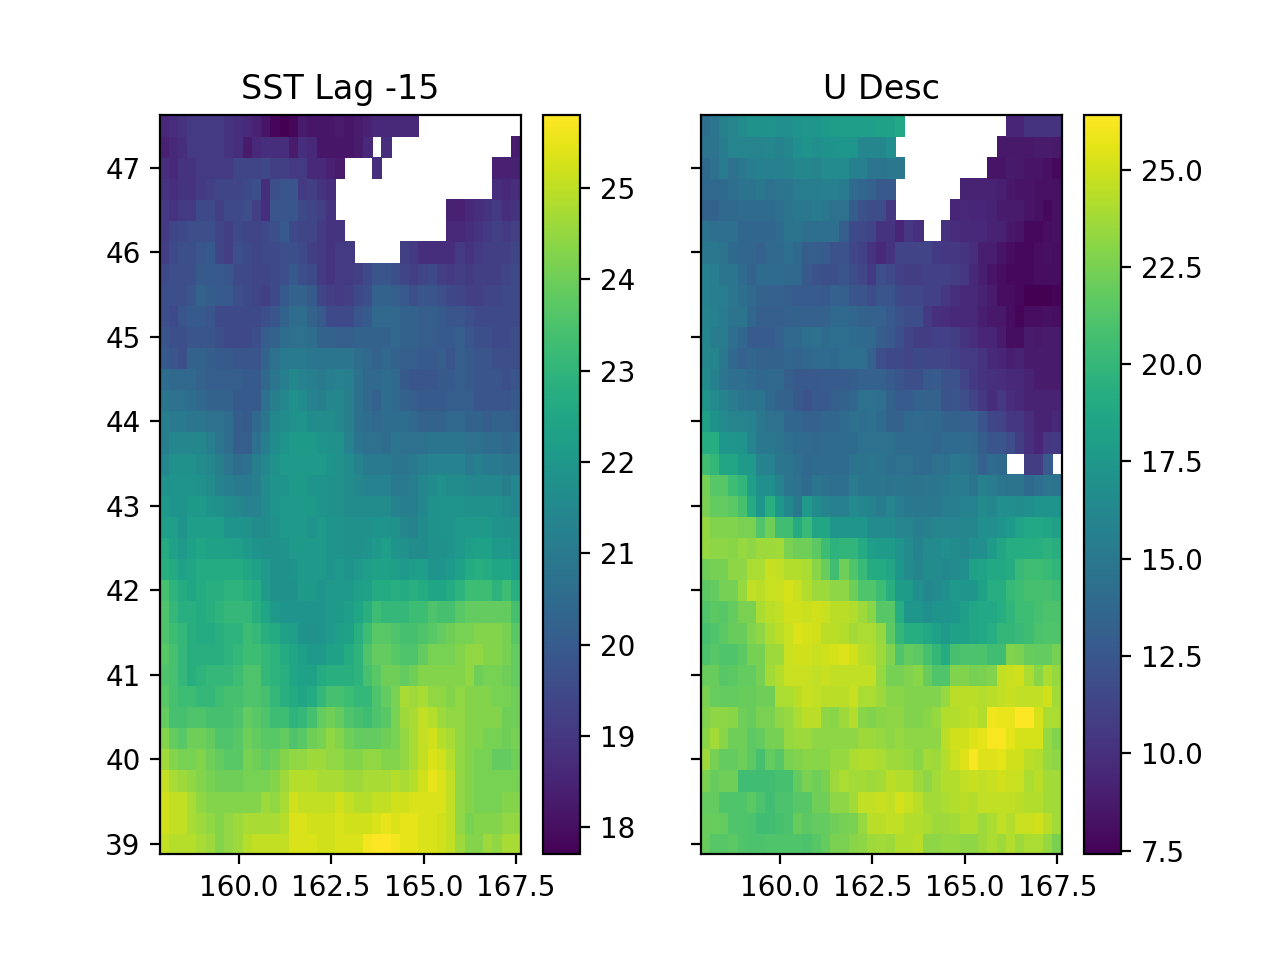

In [27]:
#plots where correlation is large
lagy = -15

lat10, lon10, sst_lagy = data_sliceA([latsl2[0]+lagy,latsl2[1]+lagy],[lonsl2[0],lonsl2[1]],sst)
lat11, lon11, wspd_lagy = data_sliceA([latsl2[0],latsl2[1]],[lonsl2[0],lonsl2[1]],wspdA)


fig, axs = plt.subplots(ncols=2,sharey=True)
fig.subplots_adjust(hspace=.5)

ax1 = axs[0]
pc = ax1.pcolormesh(lon10,lat8,sst_lagy)
ax1.set_title('SST Lag -15')
cbar1 = fig.colorbar(pc,ax=ax1)

ax2 = axs[1]
pc = ax2.pcolormesh(lon11,lat11,wspd_lagy)
ax2.set_title('U Desc')
cbar2 = fig.colorbar(pc,ax=ax2)